In [2]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm
from tqdm import tqdm
import seaborn as sns

plt.rcParams.update({'font.size': 12, 'font.serif':'Palatino'})

# Hopfield Networks

A Hopfield network is defined by a sequence of $N$ binary neurons:
$$r_i(t) \in \{0,1\} \hspace{0.2cm} \forall i$$

The update rule is given by:
$$r_i(t+\Delta t) = F \left(\sum_{j=1}^N W_{ij}r_j(t)\right)$$

where 
\begin{equation}
    F(x) = \left\{\begin{array}{ll}
    1    &  \textrm{if } x >0\\
    0    & \textrm{otherwise }
    \end{array}
    \right.
\end{equation}

and $W$ is the synaptic connectivity matrix, which is kept fixed: plasticity does not play a role.

For a given sequence, the synaptic weight matrix is given by:
$$W_{ij} = \sum_{m=1}^M \left(r_i^{(m)}-\frac{1}{2}\right)\left(r_j^{(m)}-\frac{1}{2}\right)$$
$$W_{ii} = 0$$

### 1.1 Hopfield Network Derivations
The aim is to predict the probability of recalling a bit incorrectly (‘error probability’) in a network of $N = 100$ and $N = 1000$ neurons as $M = 1, 2, . . ., 100, 200, 500, 1000$ random patterns are stored. Each bit of the pattern has 0.5 probability of being 1, and bits are sampled independently from each other and across memorised patterns.

Define the weighted sum of the inputs to neuron $k$ as: $$H_k(t) = \sum_{j\neq k}W_{kj}r_j(t)$$
Substitute in our expression for the synaptic weight matrix:

$$H_k(t) = \sum_{j\neq k}\sum_{m=1}^M \left(r_k^{(m)}-\frac{1}{2}\right)\left(r_j^{(m)}-\frac{1}{2}\right)r_j(t)$$
$$ = \sum_{m=1}^M \left(r_k^{(m)}-\frac{1}{2}\right)\sum_{j\neq k}r_j(t) \left(r_j^{(m)}-\frac{1}{2}\right)$$
When we are in memory state $ m = \mu$, then $r_j(t) = r_j^{(\mu)}$, and so we can decompose the expression into a signal and a noise term:
$$H_k|r_k^{(\mu)} = \left(r_k^{(\mu)}-\frac{1}{2}\right)\sum_{j\neq k}r_j^{(\mu)} \left(r_j^{(\mu)}-\frac{1}{2}\right) + \sum_{j\neq k} r_j^{(\mu)} \sum_{m \neq \mu}\left(r_j^{(\mu)}-\frac{1}{2}\right) \left(r_k^{(\mu)}-\frac{1}{2}\right)$$

We can use the central limit theorem to model this as a Gaussian:
$$P(H_k|r_k = 1) \sim \mathcal{N}\left(\frac{N-1}{8}, \frac{(N-1)(M-1)}{32}\right)$$

In [5]:
capacity = lambda N, M: ((N - 1) / 8, (M - 1) * (N - 1) / 32)

The bit-error probability, $P(e)$ can thus be expressed as:
$$P(e) = 0.5\left[P(H_k<0|r_k = 1) + P(H_k > 0 |r_k = 0)\right]\\
= P(H_k < 0 |r_k=1)$$

With the Gaussian model, we see that this is none other than the Gaussian cumulative density function$$P(e) = \int_{-\infty}^0 \mathcal{N}\left(x;\frac{N-1}{8}, \frac{(N-1)(M-1)}{32}\right) dx$$

In [127]:
error = lambda N, M: norm.cdf((0 - capacity(N, M)[0])/np.sqrt(capacity(N, M)[1]))

We can visualise what happens to the probability of recalling a bit incorrectly as we increase the number $M$ of stored patterns for $N = 100$ and $N = 1000$ neurons.

In [215]:
N1 = 100
N2 = 1000
Ms_cont = np.logspace(0.01, 3, 22)
Ms_disc = sorted(list(set([int(i) for i in np.logspace(0, 3, 22)])))

In [216]:
errors1 = []
errors2 = []

for M in Ms_cont:
    errors1.append(error(N1, M))
    errors2.append(error(N2, M))

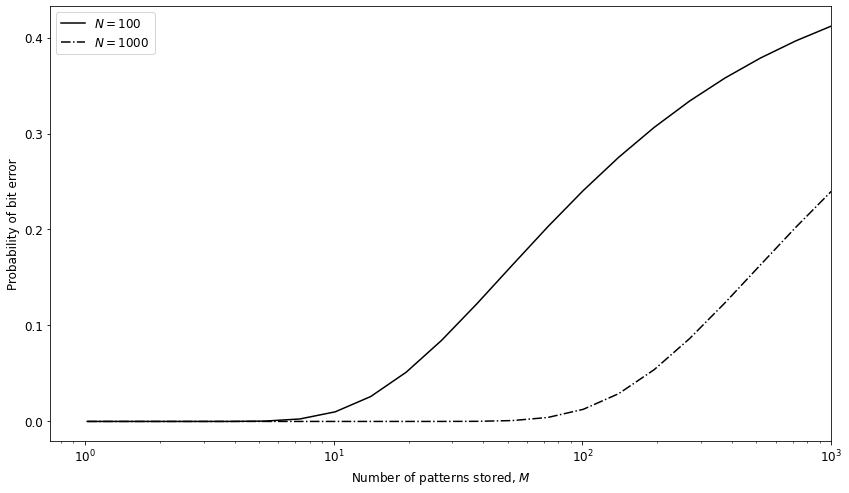

In [217]:
plt.figure(figsize=(14, 8))
plt.plot(Ms_cont, errors1, ls = '-', label='$N=100$', color = 'k')
plt.plot(Ms_cont, errors2, ls = '-.', label='$N=1000$', color = 'k')
plt.xscale('log')
plt.legend()
plt.xlabel('Number of patterns stored, $M$',)
plt.xlim(None, 1000)
plt.ylabel('Probability of bit error')
plt.show()

### 1.3 Hopfield Network Simulation
We will now run simulations of a Hopfield network consisting of $N = 100$ and $N = 1000$ neurons. For each network, we will aim to recall the $M$ stored patterns and plot the average error probability across these. The error probabilities can then be compared to the theoretically derived result.

Generates $m$ binary sequences of length $n$, each value is either $0$ or $1$ with probability $0.5$

In [218]:
draw_sequence = lambda m, n : np.asarray([np.random.binomial(1, 0.5, n) for i in range(m)]) 

The synaptic weight matrix is for that sequence is generated according to the definition:

In [219]:
form_w = lambda seq: (seq-0.5).T @ (seq-0.5) - seq.shape[0]/4 * np.eye(seq.shape[1])

The Lyapunov energy function is defined as:
$$E(\boldsymbol{r}) = -\frac{1}{2}\sum_i\sum_{j\neq i}W_{ij}r_ir_j$$

In [220]:
energy = lambda r, W: -0.5 * r @ W @ r

In [346]:
def async_update(rs, W, n):

    pred_words = []
    
    for pattern in rs:
        r = pattern.copy()
        
        e_curr = energy(r, W)
        
        while True:
            i = np.random.randint(0, n, 1)[0]
            r[i] = int(np.dot(W[i], r)>0)
            e_next = energy(r, W)
            
            if abs(e_next - e_curr) <= 1:
                break
            else:
                e_curr = e_next

        pred_words.append(r)
    return np.asarray(pred_words)

If the network is initialised in memory pattern $m \in M$, an error occurs in bit $k$ if the update rule causes neuron $k$ to change state. The error of a sequence is defined as the fraction of neurons that have flipped bits.

In [320]:
p_error = lambda x, y, m, n: np.sum(np.abs(x - y)) / (m * n)

In [321]:
def sync_update(rs, W):
    pred_words = []
    for r in rs:
        pred_words.append((r @ W > 0).astype(int))
    return np.asarray(pred_words)

In [352]:
def run_sim(m, n):
    seq = draw_sequence(m, n)
    W = form_w(seq)
    new_seq = sync_update(seq, W)
    #new_seq = async_update(seq, W, n)
    error = p_error(new_seq, seq, m, n)
    return error

In [353]:
errors1_sim = []
errors2_sim = []

for M in Ms_disc:
    errors1_sim.append(run_sim(M, N1))
    errors2_sim.append(run_sim(M, N2))

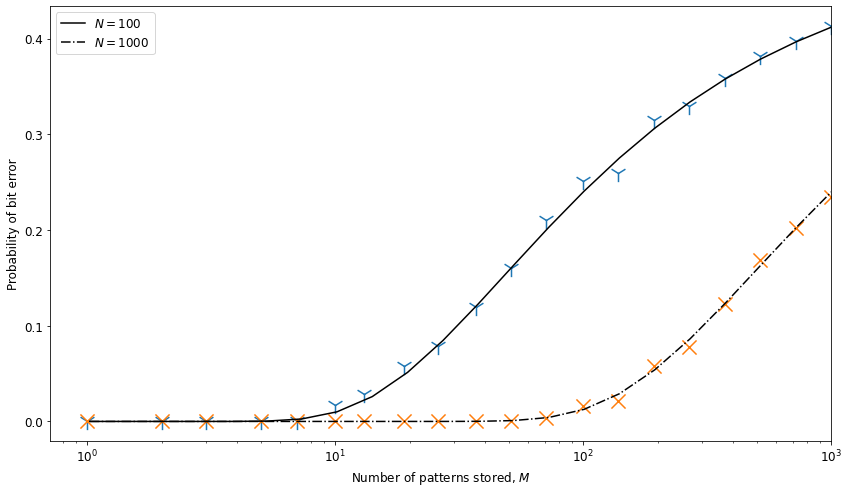

In [354]:
plt.figure(figsize=(14, 8))
plt.plot(Ms_cont, errors1, '-', label='$N=100$', color='k')
plt.plot(Ms_cont, errors2, '-.', label='$N=1000$', color='k')
plt.scatter(Ms_disc, errors1_sim, marker='1', s=300)
plt.scatter(Ms_disc, errors2_sim, marker='x', s=200)

plt.xscale('log')
plt.legend()
plt.xlabel('Number of patterns stored, $M$',)
plt.xlim(None, 1000)
plt.ylabel('Probability of bit error')
plt.show()

In [10]:
N = 100
Ms = [10, 50, 100, 250, 500, 750, 1000]
Es  = []
for M in Ms:
    seq = draw_sequence(M, N)
    W = form_w(seq)
    all_es = []
    for i in range(10):
        es = []
        r = seq[i].copy()
        for i in range(5000):
            idx = np.random.randint(0, N, 1)[0]
            r[idx] = int(np.dot(W[idx], r)>0)
            es.append(energy(r, W))
        all_es.append(es)
    Es.append(np.mean(all_es, 0))
    


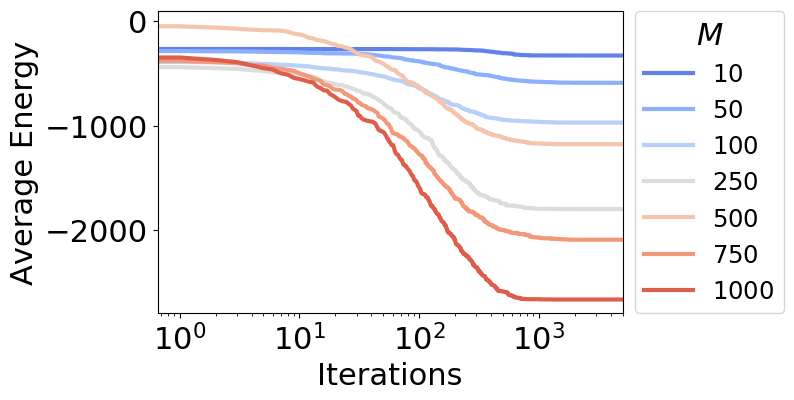

In [13]:
with sns.color_palette("coolwarm", 7):
    plt.figure(figsize=(6, 4), dpi=100)
    for idx, E in enumerate(Es):
        plt.plot(E, linewidth=3, label=r'${}$'.format(Ms[idx]))
    plt.xlabel('Iterations')
    plt.ylabel('Average Energy')
    plt.xscale('log')
    
    plt.legend(title='$M$', prop={'size': 17.5}, loc='center left', bbox_to_anchor=(1, 0.5))
    plt.xlim([None, 5000])
    #plt.legend()
    plt.show()

### 1.4 Effect of Input Noise
A network of 100 neurons with different numbers of patterns stored (try the same numbers as above). Start your network by initializing it at one of the stored patterns, but flip each bit randomly with some probability (‘input noise level’).

We can "corrupt" a sequence by randomly flipping bits with probability $p$. This can be implemented by applying the bitwise XOR operator `^` to the original sequence and another random binary sequence defined by the probability of flipping a bit, $p$.

In [227]:
corrupt = lambda seq, p: np.random.binomial(1, p, size=seq.shape) ^ seq.copy()

In [228]:
def run_sim_corrupt(m, n, p):
    seq = draw_sequence(m, n)
    W = form_w(seq)
    input_seq = corrupt(seq, p)
    error = calc_error(update(input_seq, W), seq)
    return error

This is now modelled by the Gaussian:
$$P(H_k|r_k = 1) \sim \mathcal{N}\left(\frac{(N-1)(1-2p)}{8}, \frac{(N-1)(M-1)}{32}\right)$$
And so, as before, $$P(e) = \int_{-\infty}^0 \mathcal{N}\left(x;\frac{(N-1)(1-2p)}{8}, \frac{(N-1)(M-1)}{32}\right) dx$$

In [229]:
capacity2 = lambda n, m, p: ((n - 1) * (1 - 2 * p) / 8, (m - 1) * (n - 1) / 32)
error2 = lambda n, m, p: norm.cdf((0-capacity2(n, m, p)[0])/np.sqrt(capacity2(n, m, p)[1]))

We can then run the same simulation as previously, but using the corrupted sequence

In [230]:
ps = [0, 0.01, 0.02, 0.05, 0.1, 0.2, 0.5, 0.8, 0.9, 1.0]

results = {}

for p in tqdm(ps):
    mean_p_err = []
    
    for M in Ms_disc:
        p_err = []

        for i in range(250):
            p_err.append(run_sim_corrupt(M, N1, p))
            
        mean_p_err.append(np.mean(p_err, axis=0))
    
    results[p] = np.array(mean_p_err)

100%|██████████| 10/10 [03:42<00:00, 22.26s/it]


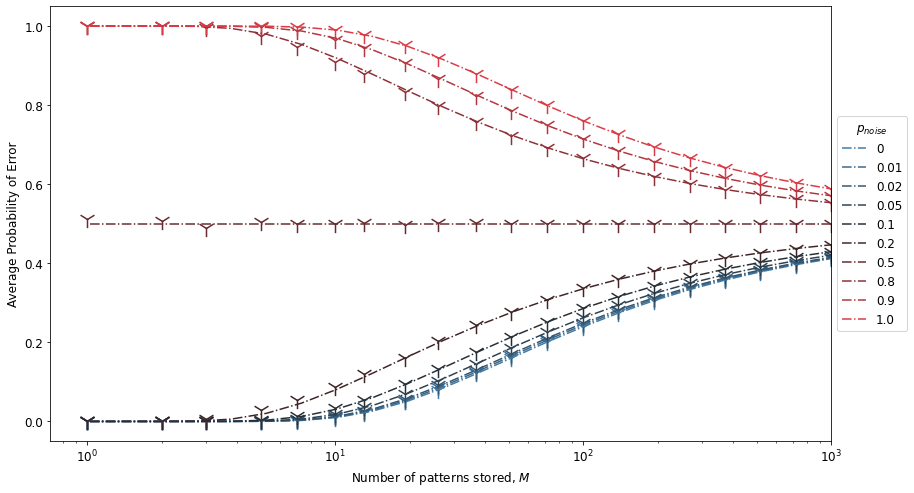

In [231]:
with sns.diverging_palette(240, 10, n=10, center = 'dark'):
    plt.figure(figsize=(14, 8))
    
    for p_noise, mean_err in results.items():
        es = [error2(N1, M, p_noise) for M in Ms_cont]

        plt.scatter(Ms, mean_err, marker='1', s=300)
        plt.plot(Ms_cont, es, '-.', label = p_noise)
        
    plt.xscale('log')
    plt.xlim([None, 1000])
    plt.xlabel(r'Number of patterns stored, $M$')
    plt.ylabel(r'Average Probability of Error')
    plt.legend(title='$p_{noise}$', prop={'size': 12}, loc='center left', bbox_to_anchor=(1, 0.5))
    plt.show()